<a href="https://colab.research.google.com/github/CsanyiDavid/image_inpainting/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps:

* Load Imagenet images ✅
* Write datagenerator ✅
* Optimize datagenerator performance
* Read about models used for inpainting
* Create a neural network
* Loss function and training
* Visualise results

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab import userdata
import os
from tqdm import tqdm

# Load images

In [7]:
!pip install kaggle --quiet
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
!kaggle datasets download -d lijiyu/imagenet

Dataset URL: https://www.kaggle.com/datasets/lijiyu/imagenet
License(s): unknown
100% 6.21G/6.21G [01:29<00:00, 129MB/s] 
100% 6.21G/6.21G [01:29<00:00, 74.6MB/s]


In [ ]:
! unzip "imagenet.zip"

In [10]:
train_data_path = "imagenet/train/"
val_data_path = "imagenet/val/"

In [11]:
print(len(os.listdir(train_data_path)), len(os.listdir(val_data_path)))

45000 5000


(256, 256, 3)
float32
1.0 0.0
<class 'PIL.Image.Image'>


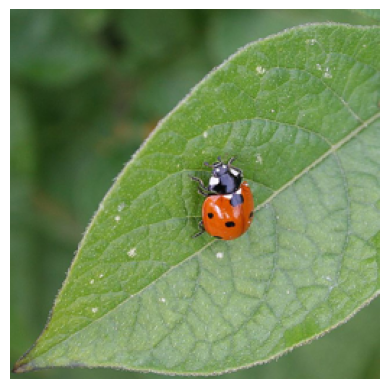

In [13]:
index = 2
image = keras.utils.load_img(train_data_path + os.listdir(train_data_path)[index])
image = image.resize((256, 256))
image_arr = keras.utils.img_to_array(image)/255.0
print(image_arr.shape)
print(image_arr.dtype)
print(np.max(image_arr), np.min(image_arr))
print(type(image))
plt.imshow(image_arr)
plt.axis('off')
plt.show()

In [ ]:
wrong_shape_cnt = 0
for filename in tqdm(os.listdir(train_data_path)):
    image = keras.utils.load_img(train_data_path + filename)
    image_arr = keras.utils.img_to_array(image)
    if len(image_arr.shape) !=3 or image_arr.shape[2] != 3:
        wrong_shape_cnt += 0

print(wrong_shape_cnt)

# Datagenerator

In [15]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, directory_path, batch_size, input_size=(256, 256), inpaint_min_size=20, inpaint_max_size=50, shuffle = True):
        if not os.path.exists(directory_path):
            raise Exception("Directory not found")
        self.directory_path = directory_path
        self.batch_size = batch_size
        self.n = len(os.listdir(directory_path))
        self.data_filenames = os.listdir(directory_path)
        self.input_size = input_size
        self.inpaint_min_size = inpaint_min_size
        self.inpaint_max_size = inpaint_max_size
        self.shuffle = shuffle

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch_filenames = self.data_filenames[index * self.batch_size: (index + 1) * self.batch_size]
        batch_images = []
        for filename in batch_filenames:
            image = self.load_image(filename)
            batch_images.append(image)
        masked_images = [self.mask_image(np.copy(im)) for im in batch_images]
        x_data = np.stack(masked_images, axis=0)
        y_data = np.stack(batch_images, axis=0)
        return x_data, y_data

    def load_image(self, filename):
        image = keras.utils.load_img(self.directory_path + filename)
        image = image.resize(self.input_size)
        image_arr = keras.utils.img_to_array(image)/255.0
        return image_arr

    def mask_image(self, image):
        x_size = np.random.randint(self.inpaint_min_size, self.inpaint_max_size)
        y_size = np.random.randint(self.inpaint_min_size, self.inpaint_max_size)
        x_middle = np.random.randint(x_size, self.input_size[0]-x_size)
        y_middle = np.random.randint(y_size, self.input_size[1]-y_size)
        image[x_middle-x_size:x_middle+x_size, y_middle-y_size:y_middle+y_size, :] = 0
        return image

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.data_filenames)


In [16]:
dg = DataGenerator(train_data_path, 8)
len(dg)

5625

(8, 256, 256, 3) (8, 256, 256, 3)
float32


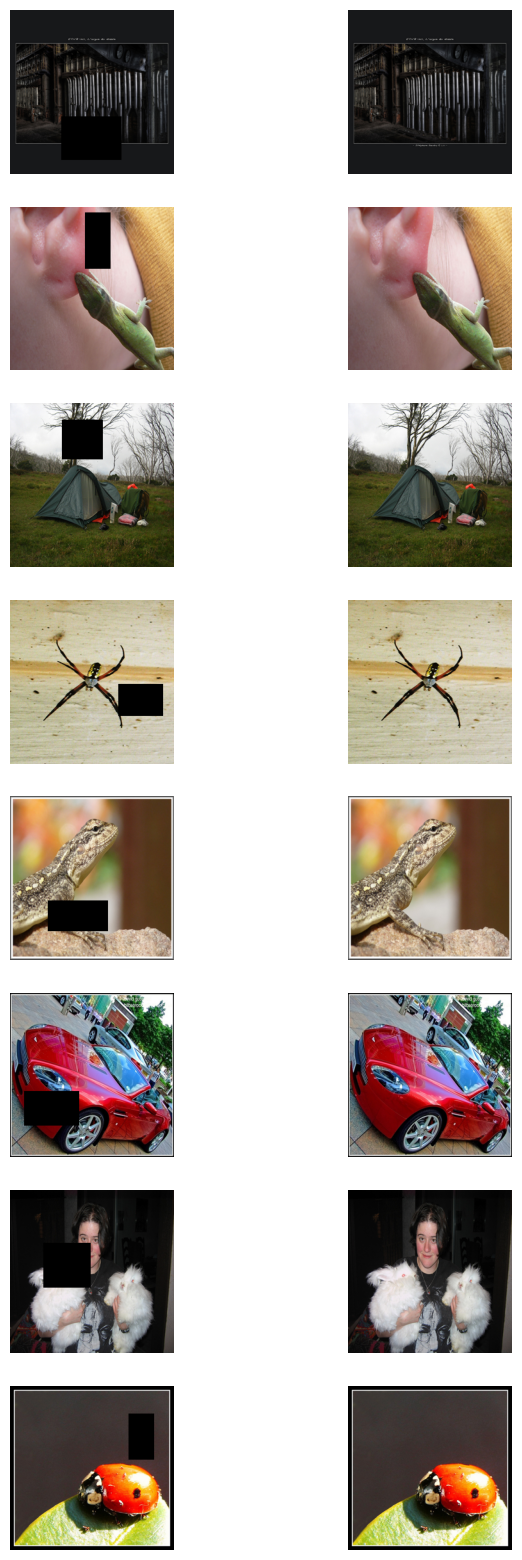

In [17]:
x, y = dg[1]
print(x.shape, y.shape)
print(x.dtype)

fig, axs = plt.subplots(8, 2, figsize=(8, 20))
plt.axis('off')
for i in range(8):
    axs[i, 0].imshow(x[i])
    axs[i, 0].axis('off')
    axs[i, 1].imshow(y[i])
    axs[i, 1].axis('off')
plt.show()

# U-Net model implementation

In [70]:
class DownBlock(keras.layers.Layer):
    def __init__(self, filters, pooling=True):
        super().__init__()
        self.do_pooling = pooling
        self.pool = keras.layers.MaxPooling2D()
        self.conv1 = keras.layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')
        self.conv2 = keras.layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')

    def call(self, inputs):
        if self.do_pooling:
            x = self.pool(inputs)
        else:
            x = inputs

        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UpBlock(keras.layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.up = keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest")
        self.concat = keras.layers.Concatenate(axis=3)
        self.conv1 = keras.layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')
        self.conv2 = keras.layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')

    def call(self, inputs, c):
        x = self.up(inputs)
        x = self.concat([x, c])
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [80]:
class UNet(keras.Model):
    def __init__(self):
        super().__init__()
        self.down_block1 = DownBlock(64, pooling=False)
        self.down_block2 = DownBlock(128)
        self.down_block3 = DownBlock(256)
        self.down_block4 = DownBlock(512)
        self.up_block1 = UpBlock(256)
        self.up_block2 = UpBlock(128)
        self.up_block3 = UpBlock(64)
        self.conv = keras.layers.Conv2D(1, 3, activation='relu', padding='same')

    def call(self, inputs):
        print(inputs.shape)
        d1 = self.down_block1(inputs)
        print(d1.shape)
        d2 = self.down_block2(d1)
        print(d2.shape)
        d3 = self.down_block3(d2)
        print(d3.shape)
        d4 = self.down_block4(d3)
        print(d4.shape)

        u1 = self.up_block1(d4, d3)
        print(u1.shape)
        u2 = self.up_block2(u1, d2)
        print(u2.shape)
        u3 = self.up_block3(u2, d1)
        print(u3.shape)
        u4 = self.conv(u3)
        print(u4.shape)
        return u4

In [81]:
model = UNet()

In [ ]:
x, y = dg[0]
print(x.shape, y.shape)
out = model(x)